In [63]:
__author__ = 'nipunbatra'

import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv("../main_15min_decomposition_12_daily_weekly_cluster_diff_frac_temp_weekday_200.csv",index_col=0)
dfc = df.copy()

df = df.drop(871)
df = df.drop(1169)



w=df[['aggregate_%d' %i for i in range(1,13)]]

df = df.ix[w[w>0].dropna().index]

"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',}
                       #'month_extract':['variance','ratio_min_max', 'difference_min_max',
                        #                'ratio_difference_min_max']}

"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       'trend_12':['stdev_trend_12','max_trend_12'],

                       'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],
                       'cluster_big':'cluster_big',
                       'cluster_small':'cluster_small',
                       'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       #'disag_fridge':'disag_fridge'}
                       'mins_hvac':'mins_hvac',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}

### Monthly ONLY
"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       #'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       #'trend_12':['stdev_trend_12','max_trend_12'],
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       #'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       #'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',
                       #'cluster_big':'cluster_big',
                       #'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}


"""

from itertools import combinations
features_dict = {}
for feature_size in range(1,min(4,len(features_individual))):
    combinations_size_n = list(combinations(features_individual.keys(), feature_size))
    for com in combinations_size_n:
        features_dict[com] = np.hstack([features_individual[x] for x in com]).tolist()



hvac_fhmm_pred = pd.read_csv("../fhmm_disag_new.csv", index_col=0)
fridge_fhmm_pred = pd.read_csv("../fridge_fhmm.csv", index_col=0)
appliance_fhmm = {'fridge': fridge_fhmm_pred,
                  'hvac': hvac_fhmm_pred}

national_average = {"fridge": 0.07, "hvac": 0.18, 'wm': 0.01, 'furnace': 0.09, 'dw': 0.02, 'dr': 0.04, 'light': .11}


#Normalising features
max_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].max().max()
df[["aggregate_%d" % i for i in range(1, 13)]] = df[["aggregate_%d" % i for i in range(1, 13)]].div(max_aggregate)

max_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].max().max()
df[["daily_usage_%d" % i for i in range(1, 8)]] = df[["daily_usage_%d" % i for i in range(1, 8)]].div(max_weekly)


df['area'] = df['area'].div(df['area'].max())

df['num_rooms'] = df['num_rooms'].div(df['num_rooms'].max())
df['total_occupants'] = df['total_occupants'].div(df['total_occupants'].max())
df['mins_hvac'] =  df['mins_hvac'].div(df['mins_hvac'].max())

max_cols = {}
for col in ["stdev_trend_12","stdev_seasonal_12","max_seasonal_12","max_trend_12",
            "stdev_trend_daily","stdev_seasonal_daily","max_seasonal_daily","max_trend_daily",
            "stdev_trend_weekly","stdev_seasonal_weekly","max_seasonal_weekly","max_trend_weekly","disag_fridge",
            'stdev_trend','stdev_seasonal','max_seasonal','max_trend',
            'cluster_small','cluster_big', 'temperature_corr']:
    if col in df.columns:
        max_cols[col] = dfc[col].max()
        df[col] = df[col].div(df[col].max())


# Adding new feature
aa = df[["aggregate_%d" % i for i in range(1, 13)]].copy()
df['variance'] = df[["aggregate_%d" % i for i in range(1, 13)]].var(axis=1)
df['ratio_min_max'] = aa.min(axis=1)/aa.max(axis=1)

df['difference_min_max'] = aa.max(axis=1)-aa.min(axis=1)
df['ratio_difference_min_max'] = (aa.max(axis=1)-aa.min(axis=1)).div(aa.max(axis=1))

dfs = {}
total = features_dict.values()[np.array(map(len, features_dict.values())).argmax()]
for appliance in ['fridge','hvac','dr','light','dw','wm']:
    temp=df.ix[df[['%s_%d' %(appliance, i) for i in range(1,13)]].dropna().index]
    dfs[appliance] =temp.ix[temp[total].dropna().index]
    print appliance, len(dfs[appliance])

appliance_min = {'fridge':5,'hvac':5,'wm':0,'dw':0,'dr':0,'light':0}

all_homes = {
    'dw':[  94,  370,  545,  624, 2156, 2242, 2814, 2829, 3723,
            4767, 5357,6636, 6910, 7769, 9934],
    'wm':[  94,  370,  545,  624, 2156, 2242, 2814, 3367, 3456, 3723, 3967,
            5357, 7769, 9654, 9922, 9934],
    'hvac':[  26,   94,  370,  410,  545,  624, 1283, 1642, 1953, 2129,
            2156, 2242, 2470, 2814, 2829,  3367, 3456, 3723,
            3967, 4767, 5218, 5357, 5371, 5746, 5785, 5814, 6072,
            6636, 6836, 6910, 7731, 7769, 7866, 9609, 9654, 9922, 9933, 9934],
    'fridge':[  94,  370,  410,  545,  624, 1953, 2156, 2242, 2814, 2829, 3367,
            3456, 3723, 3967, 4767, 5357, 5371, 6072, 6636, 6910, 7769, 7866],
    'light':df.index.tolist(),
        #[ 624, 1334, 2814, 2925, 2986, 3367, 3456, 3482, 3723, 3967, 4732,
        #    4767, 5814, 5817, 6072, 6266, 6910, 7016, 7429, 7731, 7769, 7866,
        #    8317, 8626, 9052, 9654, 9922],
    'dr':[  94,  370,  410, 2156, 2242, 2814, 3456, 3723, 4767,
            5785, 5814, 6072, 6636, 6836, 7731, 7769, 7866, 9654, 9922,
            9933, 9982]
}

all_homes = {appliance:dfs[appliance].index for appliance in dfs.keys()}

all_homes['fridge'] = np.array(np.setdiff1d(all_homes['fridge'], [2233, 5746, 7016]))
all_homes['hvac'] = np.array(np.setdiff1d(all_homes['hvac'], [252, 2925, 2986, 3482, 4732, 5439, 6266,
                                                              8626, 1800, 2233, 5817, 7016, 7429, 8317,
                                                              9052, 9982]))

all_homes['dw'] =  np.array(np.setdiff1d(all_homes['dw'],[2233, 7016]))
all_homes['wm'] = np.array([  94,  370,  545,  624, 2156, 2242, 2470, 2814, 3367, 3456, 3723,
            3967, 5357, 7769, 9654, 9922, 9934])


def create_predictions(appliance="hvac", feature=['num_rooms', 'total_occupants'],k=2, weights='uniform'):
    
   
    out_month = {}
    gt_month = {}
    overall_dfs = {}
    df_pred_copy = df.copy()
    #df_pred_copy = dfs[appliance].copy()
    df_pred_copy = df_pred_copy.ix[all_homes[appliance]]
    for i, month in enumerate(["%s_%d" %(appliance,i) for i in range(1,13)]):
        y = df_pred_copy[month]
        y2 = y.dropna()
        y3 = y2[y2>appliance_min[appliance]].dropna()
        df3 = df_pred_copy[feature].ix[y3.index].dropna()
        
        #df3 = df.ix[y3.index].dropna()
        y3 = y3.ix[df3.index]
        #df3 = df3.ix[appliance_fhmm[appliance].index].dropna()
        #y3 = y3.ix[df3.index]
        from sklearn.cross_validation import LeaveOneOut
        from sklearn.neighbors import RadiusNeighborsRegressor
        #clf = RadiusNeighborsRegressor(radius=k)
        clf = KNeighborsRegressor(n_neighbors=k, weights=weights)
        #clf = KNeighborsRegressor(n_neighbors=k, weights = 'distance' )
        loo = LeaveOneOut(len(df3))
        out_pred = []

        for train, test in loo:
            #clf.fit(preprocessing.normalize(df3[feature_columns[feature]].values[train]), y3.values[train])
            clf.fit(df3[feature].values[train], y3.values[train])
            #out_pred.append(clf.predict(preprocessing.normalize(df3[feature_columns[feature]].values[test])))
            out_pred.append(clf.predict(df3[feature].values[test]))

        out_pred = np.hstack(out_pred)

        out_month[i+1] = out_pred
        gt_month[i+1] = y3.values
        overall_dfs[i+1] = pd.DataFrame({"gt":y3.values, "pred":out_pred,
                                              "gt_total":dfc.ix[y3.index]["aggregate_"+str(i+1)].values}, index=y3.index)
        overall_dfs[i+1]["national average"] = overall_dfs[i+1]["gt_total"]*national_average[appliance]
    return overall_dfs

def percentage_error(gt, pred):
    return 100*np.abs(gt-pred)/(gt)




def compute_metrics(df):
    temp = df[df.gt_total>0.0]
    temp = temp[temp.gt>temp.gt_total]
    return {"Percentage error in appliance energy":np.median(percentage_error(df["gt"], df["pred"]))
            }



fridge 34
hvac 57
dr 35
light 24
dw 31
wm 28


In [64]:
def criterion_function(feature_set):
    
    
    temp = create_predictions(appliance, feature_set, k)
    errors = {}
    for i in range(1, 13):
        errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
    error_df = pd.DataFrame(errors)
    accur_df = 100-error_df
    accur_df[accur_df<0]=0
   
    if appliance is "hvac":
         tdf = accur_df[range(5, 11)]
    else:
        tdf = accur_df
    #print tdf.dropna().median().mean(), feature_set
    return tdf.dropna().median().mean()

In [65]:
from numba import autojit, jit


def seq_forw_select(features, max_k, criterion_func, print_steps=False):
    """
    Implementation of a Sequential Forward Selection algorithm.
    
    Keyword Arguments:
        features (list): The feature space as a list of features.
        max_k: Termination criterion; the size of the returned feature subset.
        criterion_func (function): Function that is used to evaluate the
            performance of the feature subset.
        print_steps (bool): Prints the algorithm procedure if True.
    
    Returns the selected feature subset, a list of features of length max_k.

    """

    # Initialization
    feat_sub = []
    k = 0
    d = len(features)
    if max_k > d:
        max_k = d

    while True:

        # Inclusion step
        
        crit_func_max = criterion_func(feat_sub + [features[0]])
        best_feat = features[0]
        for x in features[1:]:
            crit_func_eval = criterion_func(feat_sub + [x])
            if crit_func_eval > crit_func_max:
                crit_func_max = crit_func_eval
                best_feat = x
        feat_sub.append(best_feat)
        if print_steps:
            print('include: {} -> feature_subset: {}. Accuracy: {}'.format(best_feat, feat_sub, crit_func_max))
        features.remove(best_feat)

        # Termination condition
        k = len(feat_sub)
        if k == max_k:
            break

    return feat_sub

In [66]:
a = np.hstack([["aggregate_%d" %i for i in range(1,13)],
            ["fraction_%d" %i for i in range(1,25)],
         "autocorr",
         "max_seasonal_12",
        "stdev_seasonal_12",
        "max_trend_12",
        "stdev_trend_12",
        "max_seasonal_daily",
        "stdev_seasonal_daily",
        "max_trend_daily",
        "stdev_trend_daily",
         "max_seasonal_weekly",
        "stdev_seasonal_weekly",
        "max_trend_weekly",
        "stdev_trend_weekly",
        "disag_fridge",
        "cluster_small",
        "cluster_big",
        "lt_500",
        "bet_500_1000",
        "gt_1000",
        "temperature_corr",
         ["daily_usage_%d" %i for i in range(1,8)],
        "area",
        "num_rooms",
        "total_occupants",
               ['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']

           ])

In [67]:
only_month = np.hstack([["aggregate_%d" %i for i in range(1,13)],
            ["fraction_%d" %i for i in range(1,25)],
         "autocorr",
         "max_seasonal_12",
        "stdev_seasonal_12",
        "max_trend_12",
        "stdev_trend_12",
        "max_seasonal_daily",
        "stdev_seasonal_daily",
        "max_trend_daily",
        "stdev_trend_daily",
         "max_seasonal_weekly",
        "stdev_seasonal_weekly",
        "max_trend_weekly",
        "stdev_trend_weekly",
        "disag_fridge",
        "cluster_small",
        "cluster_big",
        "lt_500",
        "bet_500_1000",
        "gt_1000",
        "temperature_corr",
         ["daily_usage_%d" %i for i in range(1,8)],
        ['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']

           ])

In [68]:
from copy import deepcopy

def plus_L_minus_R(features, max_k, criterion_func, L=3, R=2, print_steps=False):
    """
    Implementation of a "Plus l take away r" algorithm.
    
    Keyword Arguments:
        features (list): The feature space as a list of features.
        max_k: Termination criterion; the size of the returned feature subset.
        criterion_func (function): Function that is used to evaluate the
            performance of the feature subset.
        L (int): Number of features added per iteration.
        R (int): Number of features removed per iteration.
        print_steps (bool): Prints the algorithm procedure if True.
    
    Returns the selected feature subset, a list of features of length max_k.

    """
    assert(L != R), 'L must be != R to avoid an infinite loop'

    ############################
    ### +L -R for case L > R ###
    ############################

    if L > R:
        feat_sub = []
        k = 0

        # Initialization
        while True:

            # +L (Inclusion)
            if print_steps:
                print('\nInclusion from features', features)
            for i in range(L):
                if len(features) > 0:
                    crit_func_max = criterion_func(feat_sub + [features[0]])
                    best_feat = features[0]
                    if len(features) > 1:
                        for x in features[1:]:
                            crit_func_eval = criterion_func(feat_sub + [x])
                            if crit_func_eval > crit_func_max:
                                crit_func_max = crit_func_eval
                                best_feat = x
                    features.remove(best_feat)
                    feat_sub.append(best_feat)
                    if print_steps:
                        print('include: {} -> feature_subset: {} Accuracy: {}'.format(best_feat, feat_sub, crit_func_max))

            # -R (Exclusion)
            if print_steps:
                print('\nExclusion from feature_subset', feat_sub)
            for i in range(R):
                if len(features) + len(feat_sub) > max_k:
                    worst_feat = len(feat_sub)-1
                    worst_feat_val = feat_sub[worst_feat]
                    crit_func_max = criterion_func(feat_sub[:-1])

                    for j in reversed(range(0,len(feat_sub)-1)):
                        crit_func_eval = criterion_func(feat_sub[:j] + feat_sub[j+1:])
                        if crit_func_eval > crit_func_max:
                            worst_feat, crit_func_max = j, crit_func_eval
                            worst_feat_val = feat_sub[worst_feat]
                    del feat_sub[worst_feat]
                    if print_steps:
                        print('exclude: {} -> feature subset: {} Accuracy: {}'.format(worst_feat_val, feat_sub, crit_func_max))


            # Termination condition
            k = len(feat_sub)
            if k == max_k:
                break

        return feat_sub

    ############################
    ### +L -R for case L < R ###
    ############################

    else:
        # Initialization
        feat_sub = deepcopy(features)
        k = len(feat_sub)
        i = 0
        count = 0
        while True:
            count += 1
            # Exclusion step
            removed_feats = []
            if print_steps:
                print('\nExclusion from feature subset', feat_sub)
            for i in range(R):
                if len(feat_sub) > max_k:
                    worst_feat = len(feat_sub)-1
                    worst_feat_val = feat_sub[worst_feat]
                    crit_func_max = criterion_func(feat_sub[:-1])

                    for i in reversed(range(0,len(feat_sub)-1)):
                        crit_func_eval = criterion_func(feat_sub[:i] + feat_sub[i+1:])
                        if crit_func_eval > crit_func_max:
                            worst_feat, crit_func_max = i, crit_func_eval
                            worst_feat_val = feat_sub[worst_feat]
                    removed_feats.append(feat_sub.pop(worst_feat))
            if print_steps:
                print('exclude: {} -> feature subset: {} Accuracy: {}'.format(removed_feats, feat_sub, crit_func_max))

            # +L (Inclusion)
            included_feats = []
            if len(feat_sub) != max_k:
                for i in range(L):
                    if len(removed_feats) > 0:
                        crit_func_max = criterion_func(feat_sub + [removed_feats[0]])
                        best_feat = removed_feats[0]
                        if len(removed_feats) > 1:
                            for x in removed_feats[1:]:
                                crit_func_eval = criterion_func(feat_sub + [x])
                                if crit_func_eval > crit_func_max:
                                    crit_func_max = crit_func_eval
                                    best_feat = x
                        removed_feats.remove(best_feat)
                        feat_sub.append(best_feat)
                        included_feats.append(best_feat)
                if print_steps:
                    print('\nInclusion from removed features', removed_feats)
                    print('include: {} -> feature_subset: {} Accuracy: {}'.format(included_feats, feat_sub, crit_func_max))

            # Termination condition
            k = len(feat_sub)
            if k == max_k:
                break
            if count >= 30:
                break
        return feat_sub

In [69]:
k=2
appliance="fridge"

%timeit best=seq_forw_select(features=a.tolist(), max_k=2, criterion_func=criterion_function, print_steps=True)

KeyboardInterrupt: 

In [10]:
k=1
appliance="fridge"

%timeit best=seq_forw_select(features=a.tolist(), max_k=2, criterion_func=criterion_function, print_steps=True)

include: aggregate_1 -> feature_subset: ['aggregate_1']. Accuracy: 80.3918785047
include: bet_500_1000 -> feature_subset: ['aggregate_1', 'bet_500_1000']. Accuracy: 79.7795840432
include: aggregate_1 -> feature_subset: ['aggregate_1']. Accuracy: 80.3918785047
include: bet_500_1000 -> feature_subset: ['aggregate_1', 'bet_500_1000']. Accuracy: 79.7795840432
include: aggregate_1 -> feature_subset: ['aggregate_1']. Accuracy: 80.3918785047
include: bet_500_1000 -> feature_subset: ['aggregate_1', 'bet_500_1000']. Accuracy: 79.7795840432
include: aggregate_1 -> feature_subset: ['aggregate_1']. Accuracy: 80.3918785047
include: bet_500_1000 -> feature_subset: ['aggregate_1', 'bet_500_1000']. Accuracy: 79.7795840432
1 loops, best of 3: 1min 7s per loop


In [ ]:
#for appliance in ["fridge","wm","light","dr","dw"]:
for appliance in ["dr"]:
    print "*"*20
    print appliance
    print "*"*20
    for k in range(2, 8):
        print "+"*20
        print k
        best=seq_forw_select(features=a.tolist(), max_k=25,
                      criterion_func=criterion_function, print_steps=True)
        
        

In [101]:
feature = ['daily_usage_1', 'aggregate_12', 'bet_500_1000', 'aggregate_11', 'daily_usage_3', 'aggregate_2']

In [320]:
feature=['total_occupants']
feature = ['daily_usage_7','total_occupants','daily_usage_6', 'daily_usage_1']
k=2

In [321]:
temp = create_predictions('wm',feature,5)

In [322]:
errors = {}
for i in range(1, 13):
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

In [323]:
len(accur_df.dropna().mean(axis=1).index)

16

In [324]:
accur_df.dropna().median().mean()

59.361475535531554

In [118]:
%matplotlib inline

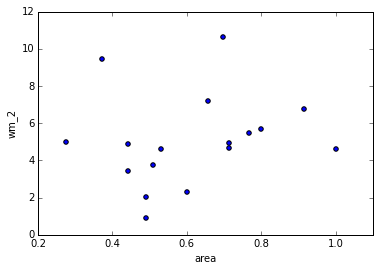

In [132]:
m=2
wm = 'wm_%d' %m
feature_plot="area"
df.ix[all_homes["wm"]][[feature_plot,wm]].plot(kind="scatter", x=feature_plot,y=wm)

In [61]:
temp = create_predictions('hvac',['aggregate_8', ],2)
errors = {}
for i in range(1, 13):
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

In [62]:
accur_df.dropna().median().ix[5:10].mean()

75.330217355607047

In [3]:
import pandas as pd
st = pd.HDFStore("/Users/nipunbatra/Downloads/wiki-temp.h5")

In [4]:
df = st['/26']['use']['2013'].resample("15T").dropna()

In [4]:
from statsmodels.tsa.stattools import pacf, acf

In [5]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

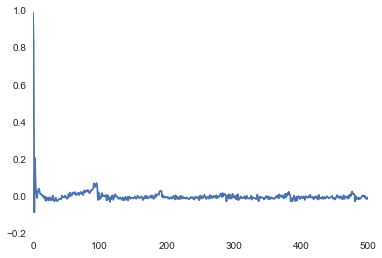

In [25]:
plt.plot(pacf(df, nlags=500))

In [28]:
a=acf(df, nlags=500)

In [31]:
b=pd.Series(a)

In [33]:
b.sort()

In [36]:
import statsmodels.api as sm


In [57]:
arma_mod20 = sm.tsa.ARMA(df[:len(df)/2], (2,0)).fit()

In [55]:
df.index.tz = None

In [56]:
df.index[len(df)/2], df.index[-1]

(Timestamp('2013-07-02 11:00:00'), Timestamp('2014-01-01 05:45:00'))

In [59]:
predict_sunspots = arma_mod20.predict('2013-07-02 06:00:00',  '2013-12-31 23:45:00', dynamic=True)


In [72]:
%matplotlib qt

In [73]:
predict_sunspots.plot()
df[len(df)/2:].plot()

In [55]:
df = st['/1953']['use']['2013'].resample("1D").dropna()

In [56]:
import statsmodels.api as sm
s = sm.tsa.AR(df)

In [57]:
s.select_order(maxlag=12, ic='aic')

7

In [16]:
s.predict()

TypeError: predict() takes at least 2 arguments (1 given)

In [61]:
out = {}
for home in df.index:
    
    d = st['/%d' %home]['use']['2013'].resample("1D").dropna()
    s = sm.tsa.AR(d)
    out[home] = s.select_order(maxlag=12, ic='aic')
    print home, out[home]

26
94
252
370
410
545
624
1283
1334
1642
1800
1953
2129
2156
2233
2242
2470
2814
2829
2925
2986
3224
3367
3456
3482
3723
3967
4732
4767
5218
5357
5371
5439
5746
5785
5814
5817
6072
6266
6636
6836
6910
7016
7429
7731
7769
7850
7866
8317
8626
9052
9609
9654
9922
9933
9934
9982


/Users/nipunbatra/anaconda/lib/python2.7/site-packages/statsmodels-0.8.0-py2.7-macosx-10.5-x86_64.egg/statsmodels/base/model.py:448: RuntimeWarning: Inverting hessian failed, no bse or cov_params available
  warn(warndoc, RuntimeWarning)


In [62]:
dfc = df.copy()

In [63]:
df['order'] = pd.Series(out)

In [68]:
%matplotlib inline

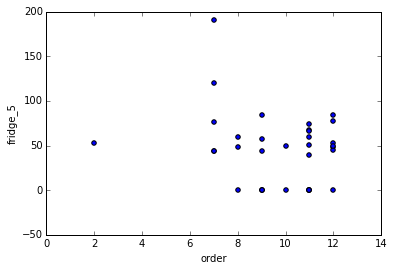

In [71]:
df.plot(kind="scatter", x="order",y="fridge_5")

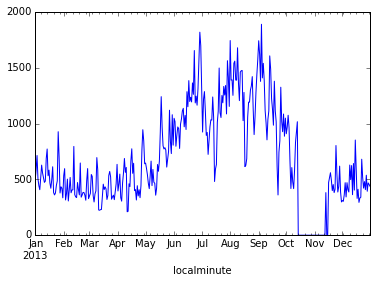

In [74]:
d.plot()

In [78]:
s = sm.tsa.AR(d)

In [83]:
params = s.fit()

In [85]:
s.predict(params=params)

TypeError: unsupported operand type(s) for *: 'float' and 'ARResultsWrapper'

In [86]:
%load_ext rmagic  


/Users/nipunbatra/anaconda/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


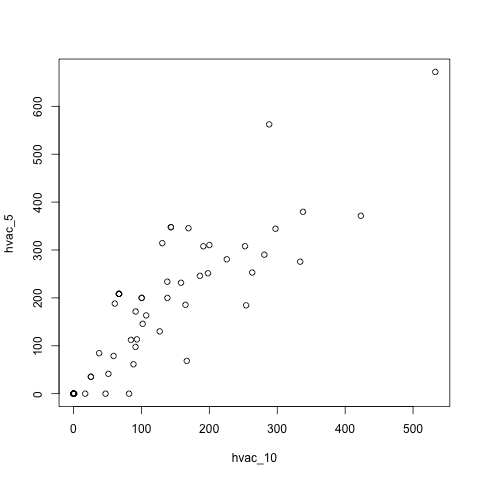

In [89]:
%R -i df plot(hvac_5~hvac_10, data=df)  

In [90]:
d

localminute
2013-01-01 00:00:00-06:00    492.518738
2013-01-02 00:00:00-06:00    588.590942
2013-01-03 00:00:00-06:00    714.093079
2013-01-04 00:00:00-06:00    503.877777
2013-01-05 00:00:00-06:00    442.747925
2013-01-06 00:00:00-06:00    407.702789
2013-01-07 00:00:00-06:00    517.796509
2013-01-08 00:00:00-06:00    627.989563
2013-01-09 00:00:00-06:00    557.663879
2013-01-10 00:00:00-06:00    515.801392
2013-01-11 00:00:00-06:00    473.145142
2013-01-12 00:00:00-06:00    484.515289
2013-01-13 00:00:00-06:00    687.763184
2013-01-14 00:00:00-06:00    772.415955
2013-01-15 00:00:00-06:00    532.606262
2013-01-16 00:00:00-06:00    583.056274
2013-01-17 00:00:00-06:00    467.077789
2013-01-18 00:00:00-06:00    420.681244
2013-01-19 00:00:00-06:00    497.317352
2013-01-20 00:00:00-06:00    613.236084
2013-01-21 00:00:00-06:00    382.402771
2013-01-22 00:00:00-06:00    360.840973
2013-01-23 00:00:00-06:00    377.575684
2013-01-24 00:00:00-06:00    445.120819
2013-01-25 00:00:00-06:00   

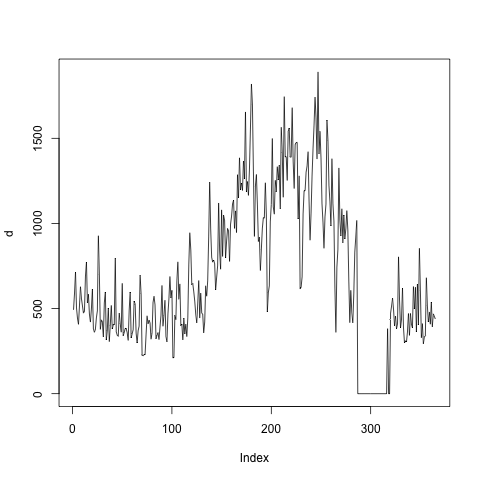

In [92]:

%R -i d plot(d, type='line')  

In [102]:
%R -i d print(summary(ts(d)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   387.7   585.5   691.3  1026.0  1890.0 


In [96]:
%R -i d plot(stl(ts(d)),"per")  


Error in stl(ts(d)) : series is not periodic or has less than two periods


/Users/nipunbatra/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in stl(ts(d)) : series is not periodic or has less than two periods

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [98]:
%R lag1.plot(dljj, 9)


Error in withVisible({ : could not find function "lag1.plot"


/Users/nipunbatra/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : could not find function "lag1.plot"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [104]:
import rpy2.robjects as ro